In [2]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-10-11 23:23:02--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 2606:4700:20::ac43:4695, 2606:4700:20::681a:321, 2606:4700:20::681a:221, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|2606:4700:20::ac43:4695|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.002s  

2025-10-11 23:23:02 (21.8 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


# 1- Exploratory Data Analysis

Before modeling, we explore the data to understand relationships between variables

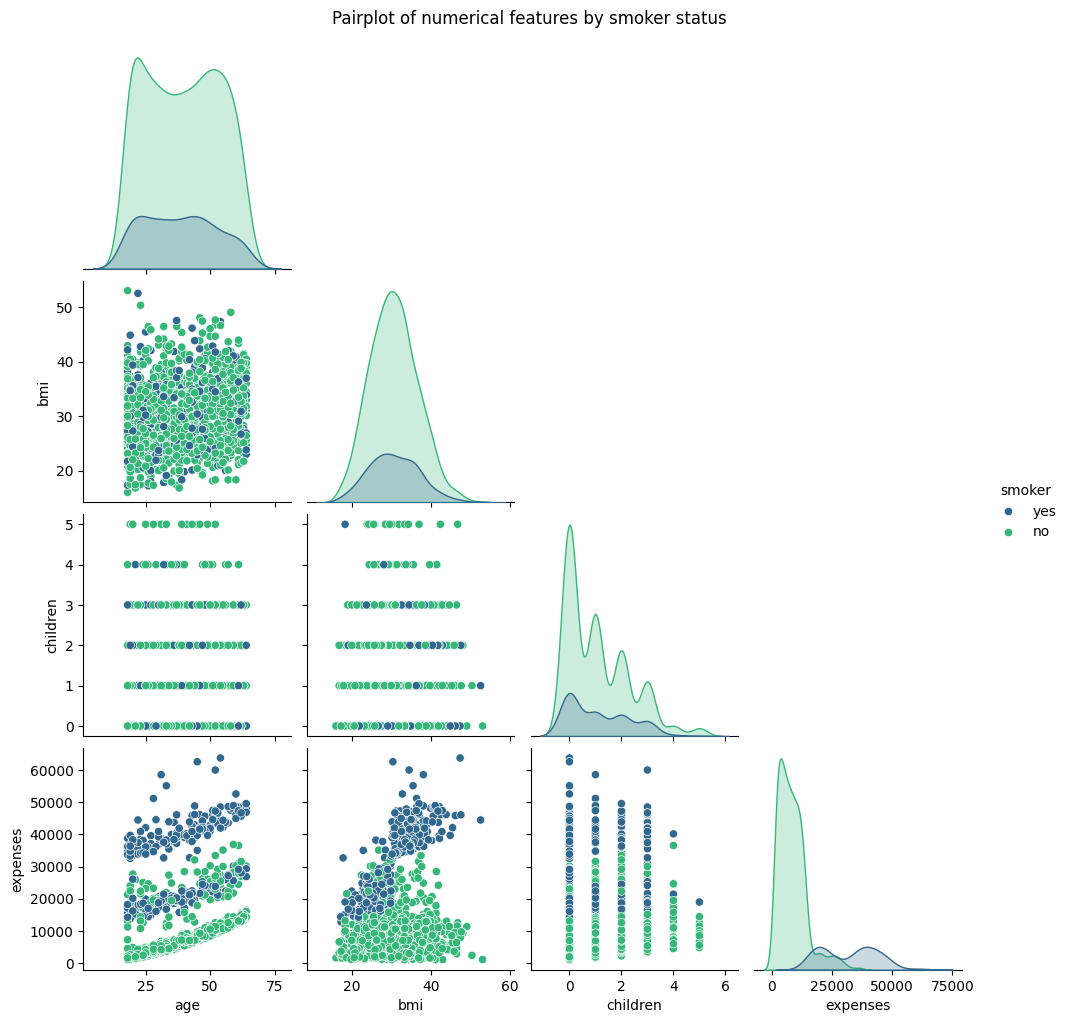

In [4]:
# Pairplot shows relationships between all numerical variables, colored by 'smoker'
sns.pairplot(dataset, hue='smoker', palette='viridis', corner=True)
plt.suptitle('Pairplot of numerical features by smoker status', y=1.02)
plt.show()

**seaborn.pairplot:** This function creates a grid of plots showing the relationship between each pair of numerical variables.
By setting **hue='smoker'**, we can instantly see that smokers (orange dots) consistently have higher expenses than non-smokers (purple dots), especially as age and BMI increase.

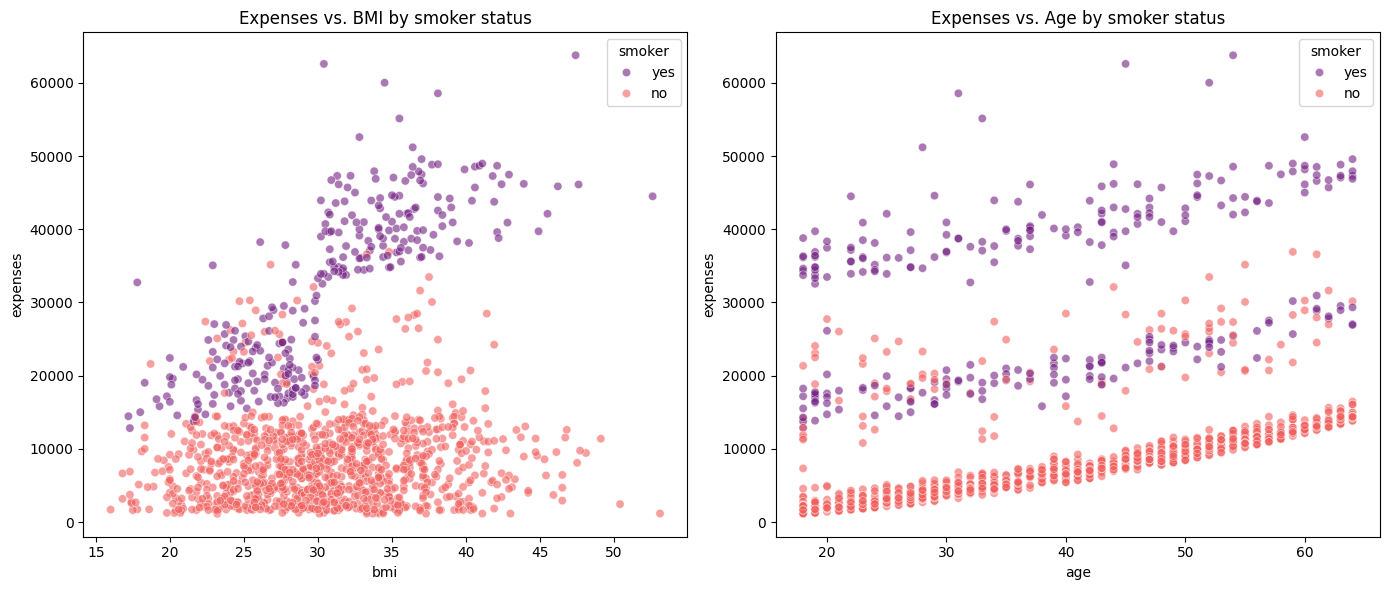

In [5]:
# A more focused look at key relationships
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(data=dataset, x='bmi', y='expenses', hue='smoker', alpha=0.6, ax=axes[0], palette='magma')
axes[0].set_title('Expenses vs. BMI by smoker status')
sns.scatterplot(data=dataset, x='age', y='expenses', hue='smoker', alpha=0.6, ax=axes[1], palette='magma')
axes[1].set_title('Expenses vs. Age by smoker status')
plt.tight_layout()
plt.show()

**seaborn.scatterplot:** We create focused scatter plots to examine the expenses vs. bmi and expenses vs. age relationships. These plots confirm that expenses rise with age and that smokers form a distinct, higher-cost group compared to non-smokers.

# 2- data processing

In [6]:



print("Preprocessing data...")
# Create a copy to avoid modifying the original dataframe during preprocessing
df_processed = dataset.copy()

# Feature Engineering: Create interaction terms
# This is a good way to capture complex relationships
df_processed['bmi_smoker'] = df_processed['bmi'] * (df_processed['smoker'] == 'yes').astype(int)

# Convert categorical columns to numerical using one-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=float)

# Separate features (X) and target (y)
X = df_processed.drop('expenses', axis=1)
y = df_processed['expenses']

# Split data into training and testing sets using scikit-learn
# This is more robust and standard than manual sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = X_train
train_labels = y_train

test_dataset = X_test
test_labels = y_test

print("Preprocessing completed.")
print("Training dataset shape:", train_dataset.shape)
print("Testing dataset shape:", test_dataset.shape)


Preprocessing data...
Preprocessing completed.
Training dataset shape: (1070, 9)
Testing dataset shape: (268, 9)


**Normalization:** A layers.Normalization layer is created and adapted only to the training data. This scales all features to a similar range, which helps the neural network train faster and more reliably.

In [7]:
# Normalize numerical features using a Keras layer
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train)) # Adapt the normalizer only on the training data


2025-10-11 23:23:18.176455: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 3- build the model

**Architecture**: The model consists of the normalization layer followed by two hidden Dense layers (with 128 and 64 neurons, respectively) using the 'ReLU' activation function, and a final Dense layer with a single neuron to output the predicted expense.

**Compiler:** The model is compiled with the Adam optimizer and uses Mean Absolute Error (MAE) as its primary loss function, as it is easily interpretable in terms of dollar error.

In [8]:

def build_model(normalizer_layer):
    model = keras.Sequential([
        normalizer_layer,
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error',
        metrics=['mae', 'mse']
    )
    return model

model = build_model(normalizer)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (1070, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

# training the model

The model is trained using the .fit() method on the training data .

**Early Stopping:** We use an EarlyStopping callback to monitor the validation loss. If the loss on the validation set does not improve for a set number of epochs (patience=15), training is stopped automatically. This prevents overfitting and saves computational time. The restore_best_weights=True argument ensures the model reverts to the state with the lowest validation error.

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    train_dataset,
    train_labels,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1)
print("Training finished.")

Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13517.7100 - mae: 13517.7100 - mse: 325445408.0000 - val_loss: 12652.6826 - val_mae: 12652.6826 - val_mse: 310291776.0000
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13512.9580 - mae: 13512.9580 - mse: 325306048.0000 - val_loss: 12645.8760 - val_mae: 12645.8760 - val_mse: 310102272.0000
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13502.9111 - mae: 13502.9111 - mse: 325007072.0000 - val_loss: 12631.8213 - val_mae: 12631.8213 - val_mse: 309709696.0000
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13483.1826 - mae: 13483.1826 - mse: 324425664.0000 - val_loss: 12605.7451 - val_mae: 12605.7451 - val_mse: 308974048.0000
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13448.7021 - mae: 13448.7021 - mse: 323382912.0000 - val_loss: 12562.6094 - val_mae: 12562.6094 - val_mse: 307745888.0000
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13393.9277 - mae: 13393.9277 - mse: 

# 5- Evaluation

After training, we evaluate the model's performance.

**History Plotting:** The plot_history function visualizes the training and validation MAE and MSE over epochs. This helps diagnose if the model was overfitting or underfitting.

**Test Set Evaluation:** The model's final performance is measured on the unseen test set. This gives us a reliable estimate of how the model would perform on new data.

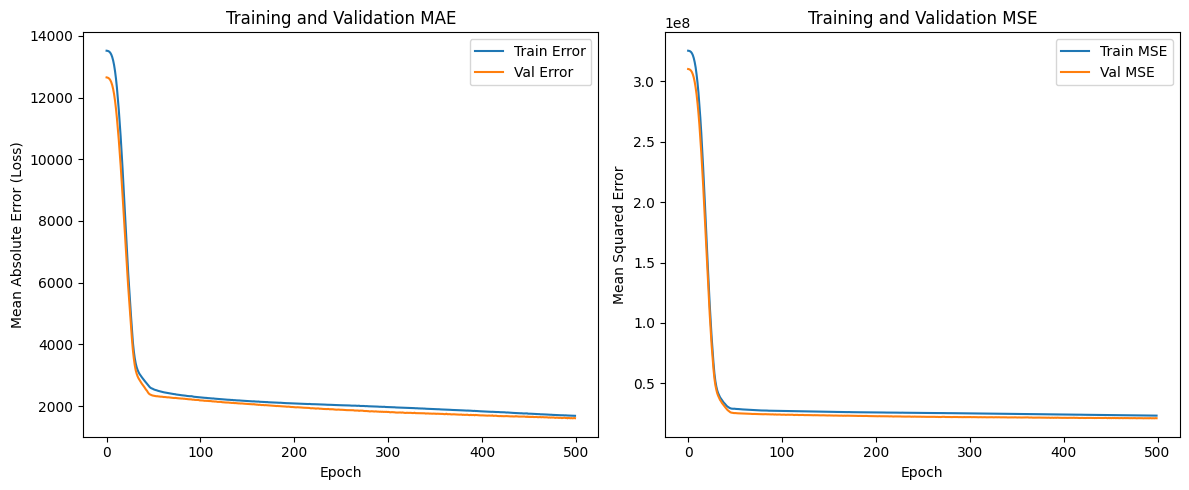

In [10]:
def plot_history(history_obj):
    hist = pd.DataFrame(history_obj.history)
    hist['epoch'] = history_obj.epoch

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (Loss)')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.legend()
    plt.title('Training and Validation MAE')


    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')
    plt.legend()
    plt.title('Training and Validation MSE')

    plt.tight_layout()
    plt.show()

plot_history(history)


9/9 - 0s - 3ms/step - loss: 1497.9636 - mae: 1497.9636 - mse: 19207988.0000
Testing set Mean Abs Error: 1497.96 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


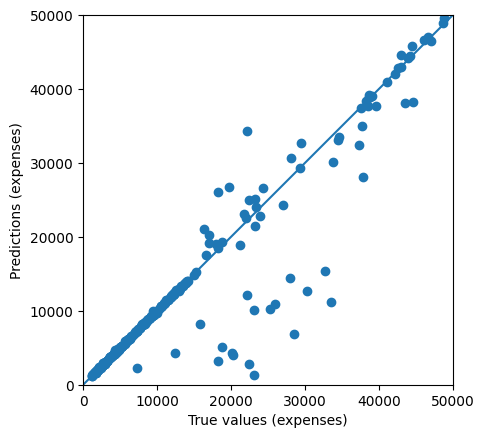

In [11]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


**Predictions vs. True Values Plot:** This scatter plot compares the model's predicted expenses against the actual expenses from the test set. A perfect model would have all points lying on the 45-degree diagonal line. This visualization provides an intuitive check of the model's accuracy across the range of values.

In [12]:
model.export('health_cost_predictor') 

INFO:tensorflow:Assets written to: health_cost_predictor/assets


INFO:tensorflow:Assets written to: health_cost_predictor/assets


Saved artifact at 'health_cost_predictor'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132454708878160: TensorSpec(shape=(1, 9), dtype=tf.float32, name=None)
  132454708877584: TensorSpec(shape=(1, 9), dtype=tf.float32, name=None)
  132454708886992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132454708887184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132454697501712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132454697503824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132454697503440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132454697504400: TensorSpec(shape=(), dtype=tf.resource, name=None)
